# <center> Testing computation of gradient using JAX

In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

In [2]:
# import general moudles
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax
import scipy
import jax.scipy as jscipy
import matplotlib.pyplot as plt


# Idea:
1. We want to minimize the function: $$ ||  e^{\tau \hat{L}} - Y_{even}^{(1)} Y_{odd}^{(2)} Y_{even}^{(3)} ||^2 $$
with $$ Y = X X^\dagger $$, for some $X \in \mathcal{C}^{m \times m}$

2. Assume all the layers are different
3. Implement the contration of the diagram. In words: 3 layers, 1st and 3rd layer are acting on the even sites, 2nd layer acting on the odd sites. We assume for $N = 6$ sites. 
4. At the moment don't assume a specific distribution, but rather just 3 layers: $Y_{i}$, $(i \in {even, odd})$
5. Once the contraction is made, I can use JAX to find the gradient wrt to each of the $Y$.
6. Use gradient descent to update maybe?. If use GDS, we can use the troterization as first step for guess.


In [4]:
# Step 1: create the cost function
from opentn.transformations import op2fullspace, dissipative2liouvillian_full
from opentn.states.qubits import get_ladder_operator

lowering = get_ladder_operator()
raising = get_ladder_operator(adjoint=True)
gamma = 1e-2 # lindbladian parameter

N = 6
d = 2

I = np.eye(d, dtype=complex)
NN = 2
# Create nearest neighbour lindbladian operator
Lnn = np.sqrt(gamma)*(op2fullspace(raising, i=0, N=NN) + op2fullspace(raising, i=1, N=NN))@(op2fullspace(lowering, i=0, N=NN) - op2fullspace(lowering, i=1, N=NN))/4
# vectorize each of the terms and add them together
Lvec = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(0, N-1):
    Lvec += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)
effective_qubits = np.log2(Lvec.shape[0])
print(f'Effective number of qubits {effective_qubits}')

Effective number of qubits 12.0


In [5]:
# Exponentiatate to get time evolving liouvillian operator
t = 1
exp_Lvec = scipy.linalg.expm(Lvec*t) # this is the exp(\hat{L}) that we should apply to the vectorization of the initial density matrix.

In [5]:
exp_Lvec.shape[0] == 2**12

True

In [6]:
from opentn.transformations import lindbladian2super
super = lindbladian2super(Li=[Lnn], dim=Lnn.shape[0])
super.shape[0] == 2**4 == 16

True

In [7]:
from opentn.transformations import vectorize

M = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
M_vec = vectorize(M)
M_vec.shape
M_vec_spread = np.reshape(M_vec, newshape=(2,2,2,2))
M_spread = M.reshape((2,2,2,2))
print(M_vec_spread[0,0,0,0])

1


In [8]:
M_spread == M_vec_spread

array([[[[ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True]]],


       [[[ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True]]]])

# <center> TIME TO ROCK:

In [156]:
# Exponential that we are comparing to: exp_Lvec

# we can define the cost function
@jit
def cost(X1, X2, X3):
   "cost function for 'troterization' of exponential"
   # check the dimensions of all the x_i are compatible with full exponential
   Xs = [X1,X2,X3]
   for X in Xs:
      assert X.shape == exp_Lvec.shape, f'Shape of tensors should be: {exp_Lvec.shape}'
   
   eff_sites = int(np.log2(exp_Lvec.shape[0]))
   
   Ys = []
   # I think the most effective way of doing thins is just making all of them into matrices no?
   for X in Xs:
      # convert each of the X into a matrix
      if X.ndim > 2:
         X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
      Y = jnp.dot(X, X.T.conj())
      Ys.append(Y)
      # y = jnp.tensordot(x, x.conj(), axes=(list(range(eff_sites)),list(range(eff_sites))))
      # Ys.append(y.reshape((exp_Lvec.shape[0], exp_Lvec.shape[1])))

   Y_total = Ys[0]
   for Y in Ys[1:]:
      Y_total = jnp.dot(Y, Y_total)
      
   return jnp.linalg.norm(vectorize(exp_Lvec) - vectorize(Y_total))

In [158]:
derivative_fn = grad(cost)

In [7]:
# In theory the first guesses could be the X1, X2, X3 comning from the cholesky decomposition of the e^odd and e^even

# Y1 and Y3:
Lvec_odd = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(0, N, 2):
    Lvec_odd += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)

print(f'Effective number of qubits { np.log2(Lvec_odd.shape[0])}')
# Y2
Lvec_even = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(1, N-1, 2):
    Lvec_even += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)

print(f'Effective number of qubits {np.log2(Lvec_even.shape[0])}')


Effective number of qubits 12.0
Effective number of qubits 12.0


In [159]:
#  NOTE: numpy version is 40 seconds slower than jax. Time: 1m 27.7s
# exp_Lvec_odd = expm(Lvec_odd*t/2) 
# exp_Lvec_even = expm(Lvec_even*t) 

In [8]:
# converting to exponential
# this is the exp(\hat{L}) that we should apply to the vectorization of the initial density matrix.
exp_Lvec_odd =scipy.linalg.expm(Lvec_odd*t/2) 
exp_Lvec_even = scipy.linalg.expm(Lvec_even*t) 

In [161]:
X1 = jnp.linalg.cholesky(exp_Lvec_odd)

In [316]:
jnp.linalg.norm(exp_Lvec_odd - exp_Lvec_odd.conj().T)

DeviceArray(0.0489286, dtype=float32)

In [317]:
jnp.linalg.norm(exp_Lvec_even - exp_Lvec_even.conj().T)

DeviceArray(0.07985022, dtype=float32)

In [162]:
Y1 = jnp.dot(X1, X1.T.conj())

In [163]:
jnp.allclose(exp_Lvec_odd, Y1)

DeviceArray(False, dtype=bool)

In [164]:
exp_Lvec_odd - Y1

DeviceArray([[0.0000000e+00+0.j, 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              ..., 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              0.0000000e+00+0.j],
             [0.0000000e+00+0.j, 5.9604645e-08+0.j, 0.0000000e+00+0.j,
              ..., 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              0.0000000e+00+0.j],
             [0.0000000e+00+0.j, 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              ..., 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              0.0000000e+00+0.j],
             ...,
             [0.0000000e+00+0.j, 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              ..., 5.9604645e-08+0.j, 0.0000000e+00+0.j,
              0.0000000e+00+0.j],
             [0.0000000e+00+0.j, 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              ..., 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              0.0000000e+00+0.j],
             [0.0000000e+00+0.j, 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              ..., 0.0000000e+00+0.j, 0.0000000e+00+0.j,
              0.0000000e+00+0.j]], dtype=com

In [165]:
X2 = jnp.linalg.cholesky(exp_Lvec_even)

In [167]:
cost_jit = jit(cost)

In [168]:
cost_jit(X1=X1, X2=X2, X3=X1) # NOTE: old value: 0.15904978 (when using t instead of t/2 in odd layer)

DeviceArray(0.06300901, dtype=float32)

In [118]:
grad_x1, grad_x2, grad_x3 = grad(cost_jit, (0,1,2))(X1, X2, X1)

In [124]:
jnp.linalg.norm(grad_x3)

DeviceArray(0., dtype=float32)

In [170]:
cost_eval, grad_x = jax.value_and_grad(cost_jit, (0,1,2))(X1, X2, X1)

In [137]:
jnp.allclose(grad[2],grad_x3)

DeviceArray(True, dtype=bool)

In [172]:
# Now we can update the X matrices and see if these reach a better cost function
# NOTE: I wrongly use t=1 instead of 1/2 for the exponential of X1 (and thus X3). We see if we can do better then
# NOTE: I fix the error
rate = 0.01
X1_new = X1 - rate*grad_x[0]
X2_new = X2 - rate*grad_x[1]
X3_new = X1 - rate*grad_x[2]

In [174]:
cost_eval

DeviceArray(0.06300901, dtype=float32)

In [173]:
cost_jit(X1=X1_new, X2=X2_new, X3=X3_new)

DeviceArray(0.06300879, dtype=float32)

In [175]:
# now lets do another optimization step!
cost_eval_2, grad_x_2 = jax.value_and_grad(cost_jit, (0,1,2))(X1_new, X2_new, X3_new)

In [176]:
X1_new2 = X1_new - rate*grad_x_2[0]
X2_new2 = X2_new - rate*grad_x_2[1]
X3_new2 = X3_new - rate*grad_x_2[2]
cost_jit(X1=X1_new2, X2=X2_new2, X3=X3_new2)

DeviceArray(0.06300857, dtype=float32)

In [178]:
jnp.linalg.norm(grad_x_2[1])

DeviceArray(0.00349943, dtype=float32)

In [180]:
jnp.linalg.norm(grad_x[1])

DeviceArray(0.00116885, dtype=float32)

In [181]:
# third step just to save some time
params_len = 3
cost_eval_3, grad_x_3 = jax.value_and_grad(cost_jit, list(range(params_len)))(*[X1_new2, X2_new2, X3_new2])

In [190]:
X1_new3 = X1_new2 - rate*grad_x_3[0]
X2_new3 = X2_new2 - rate*grad_x_3[1]
X3_new3 = X3_new2 - rate*grad_x_3[2]
cost_eval_4 = cost_jit(X1=X1_new3, X2=X2_new3, X3=X3_new3)

In [9]:
# I can let the process running for like 8 evals more. It should not much time.
# After that I will try to see if changing the cost function helps in any way.
from typing import Callable
from opentn.optimization import update

def gds(fn:Callable, x0:list, rate:float = 0.01, iter:int = 10, loss_fn=None, show_cost:bool=True) -> tuple[list, list]:
    """
    Gradient descent (GDS) optimization workflow.

    .. math:: x(i+1) = x(i) - rate*grad(fn)

    args:
    ---------
    fn:
        function to be optimized. The signature should be: (xi:parameters_to_optimimized, loss_fn:loss function)
    x0:
        initial list of parameters for optimization
    rate:
        rate to use in optimization.
    iter:
        number of iterations to repeat optimization over
        
    returns:
    ---------
        Tuple containg the cost, gradient, and parameter history over optimization.
        NOTE: the cost_eval is evaluated at the current parameters xi. So we should evaluate
        the function one last time with the final xi. len(cost_list == iter + 1)
        NOTE: update: I have changed this so that we have exactly len(cost_list == iter)
        I think this makes more sense and saves evaluation time.
        NOTE: the params_list will have len == iter + 1, since it would contain the latest update as well

    """
    if not loss_fn:
        loss_fn = lambda x,y : jnp.linalg.norm(x-y, ord='fro')

    cost_list = []
    grads_list = []
    params_list = []

    xi = x0
    num_params = len(xi)
    params_list.append(xi)

    for i in range(iter):
        print(f'Starting iteration: {i}')
        cost_eval, grad_x = jax.value_and_grad(fn, list(range(num_params)))(*xi, loss_fn=loss_fn)
        cost_list.append(cost_eval)
        grads_list.append(grad_x)
        if show_cost:
            print('* Cost function:', cost_eval)
        xi = update(xi, grad_x, rate)
        params_list.append(xi)

    return cost_list, grads_list, params_list

In [188]:
cost_list, xi = gds(fn=cost_jit, x0=[X1_new3, X2_new3, X3_new3], iter=7)

Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4
Starting iteration: 5
Starting iteration: 6


In [199]:
cost_eval_last = cost_jit(*xi)

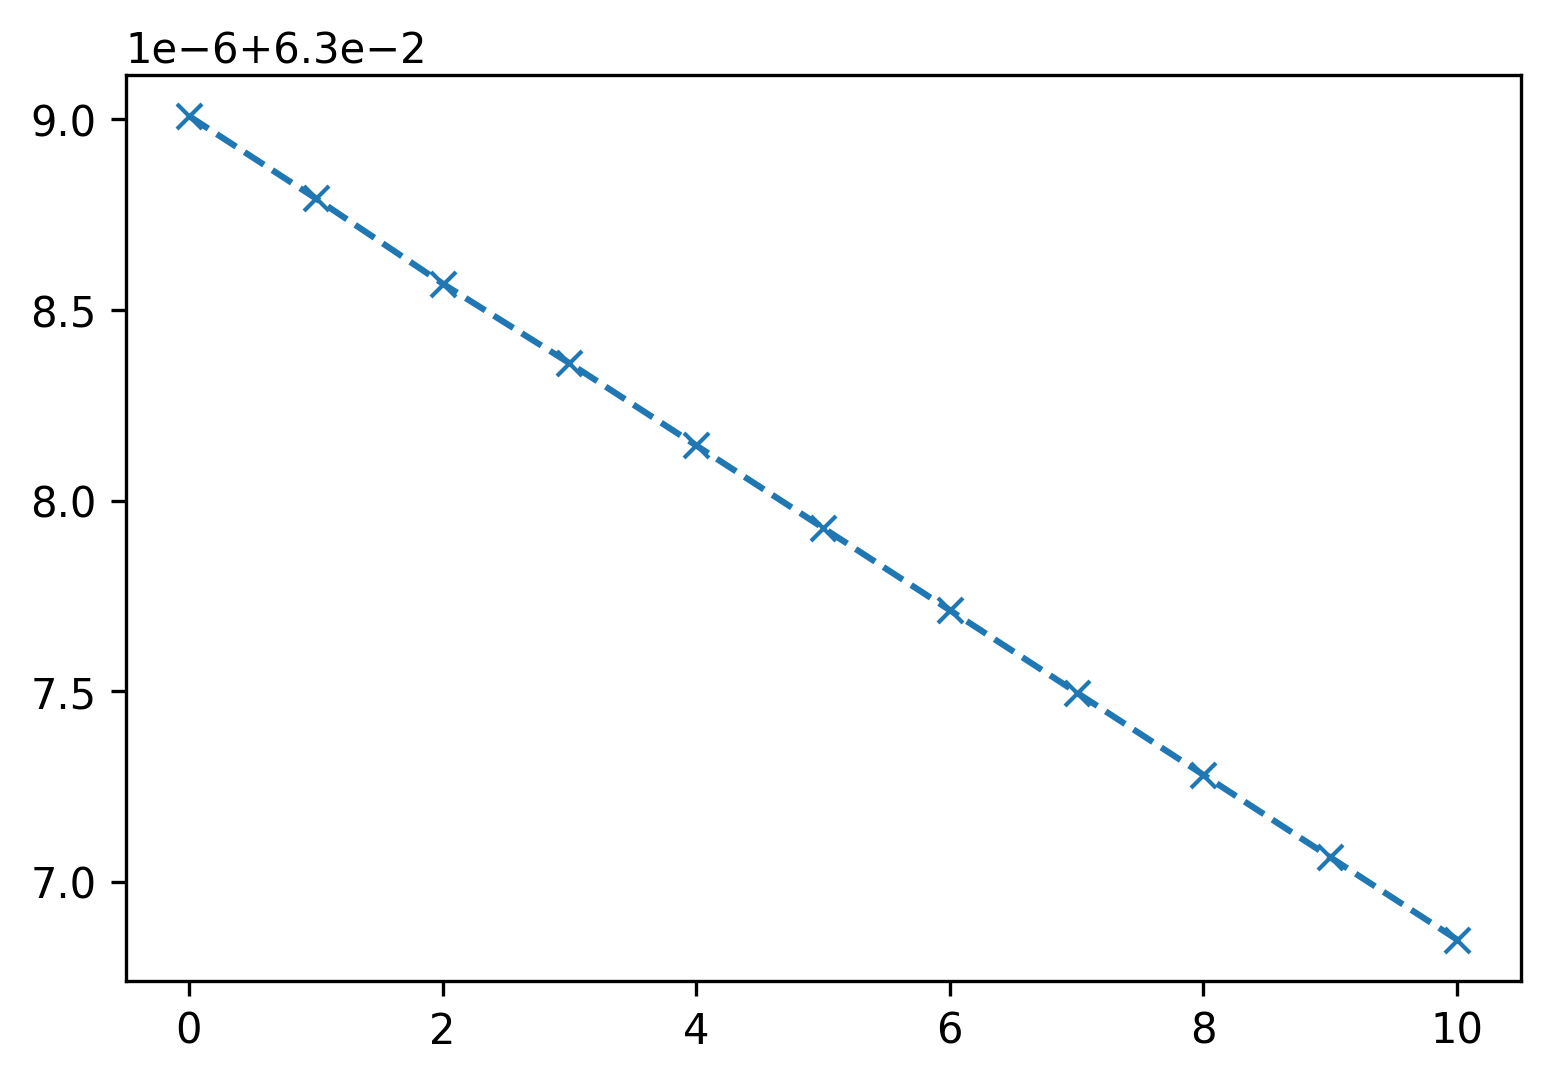

In [206]:

fig = plt.figure(dpi=300)
plt.plot(range(11), [cost_eval, cost_eval_2, cost_eval_3] + cost_list[:] + [cost_eval_last], '--x')

In [10]:
# Now I want to try if having a different cost function changes anything?
def frobenius_norm(A,B):
    return jnp.linalg.norm(A-B, ord='fro')

@jit
def contractions(Xs):
    
    Ys = []
    for X in Xs:
        # convert each of the X into a matrix
        if X.ndim > 2:
            X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
        Y = jnp.dot(X, X.T.conj())
        Ys.append(Y)
    # Here i should reshuffle the legs to go: choi-> superoperator
    Y_total = Ys[0]
    for Y in Ys[1:]:
        Y_total = jnp.dot(Y, Y_total)
    return Y_total

def cost_fn(X1, X2, X3, loss_fn):
    "cost function for 'troterization' of exponential. The choi matrix is the one that should be PSD"
    # check the dimensions of all the x_i are compatible with full exponential
    Xs = [X1,X2,X3]
    for X in Xs:
        assert X.shape == exp_Lvec.shape, f'Shape of tensors should be: {exp_Lvec.shape}'
    
    Y_total = contractions(Xs)
    assert exp_Lvec.ndim == Y_total.ndim == 2, 'Y_total should be a matrix'
    return jit(loss_fn)(exp_Lvec, Y_total)

In [301]:
cost_fn(X1, X2, X1, loss_fn=frobenius_norm)

DeviceArray(0.063009, dtype=float32)

In [234]:
cost_list_fro, xi_fro = gds(fn=cost_fn, x0=[X1, X2, X1], iter=10, loss_fn=frobenius_norm)

Starting iteration: 0
we reach here
Starting iteration: 1
we reach here
Starting iteration: 2
we reach here
Starting iteration: 3
we reach here
Starting iteration: 4
we reach here
Starting iteration: 5
we reach here
Starting iteration: 6
we reach here
Starting iteration: 7
we reach here
Starting iteration: 8
we reach here
Starting iteration: 9
we reach here
we reach here


frobenius norm: 
 initial: 0.06300900131464005 
 final: 0.06300684064626694
2-norm: 
 initial: 0.06300900876522064 
 final: 0.06300684809684753


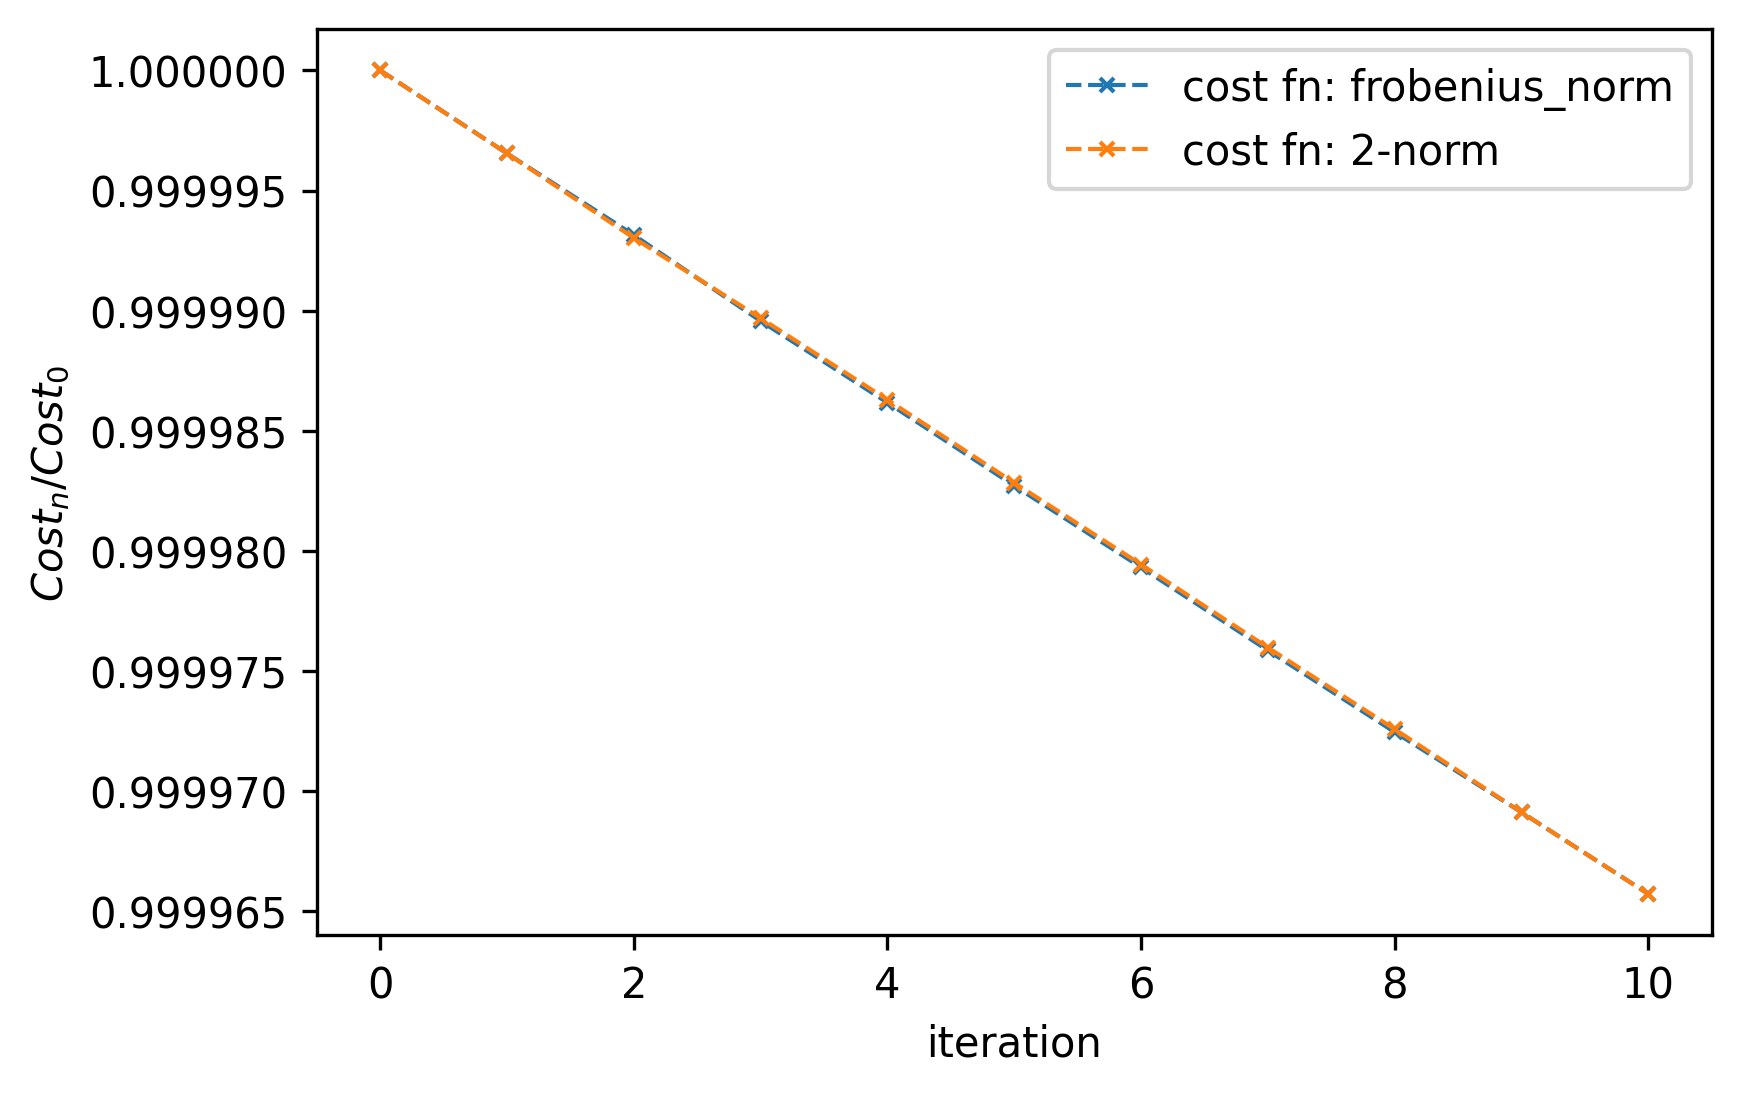

In [319]:
cost_list_2norm = [cost_eval, cost_eval_2, cost_eval_3] + cost_list[:] + [cost_eval_last]

fig = plt.figure(dpi=300)
plt.plot(range(11), [c/cost_list_fro[0] for c in cost_list_fro], '--x', label='cost fn: frobenius_norm', markersize=3.5, linewidth=1.0)
plt.plot(range(11), [c/cost_list_2norm[0] for c in cost_list_2norm], '--x', label='cost fn: 2-norm', markersize=3.5, linewidth=1.0)
plt.ylabel(r'$Cost_n/Cost_0$')
plt.xlabel('iteration')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

print(f'frobenius norm: \n initial: {cost_list_fro[0]} \n final: {cost_list_fro[-1]}')
print(f'2-norm: \n initial: {cost_list_2norm[0]} \n final: {cost_list_2norm[-1]}')

difference between functions: 7.450580596923828e-09


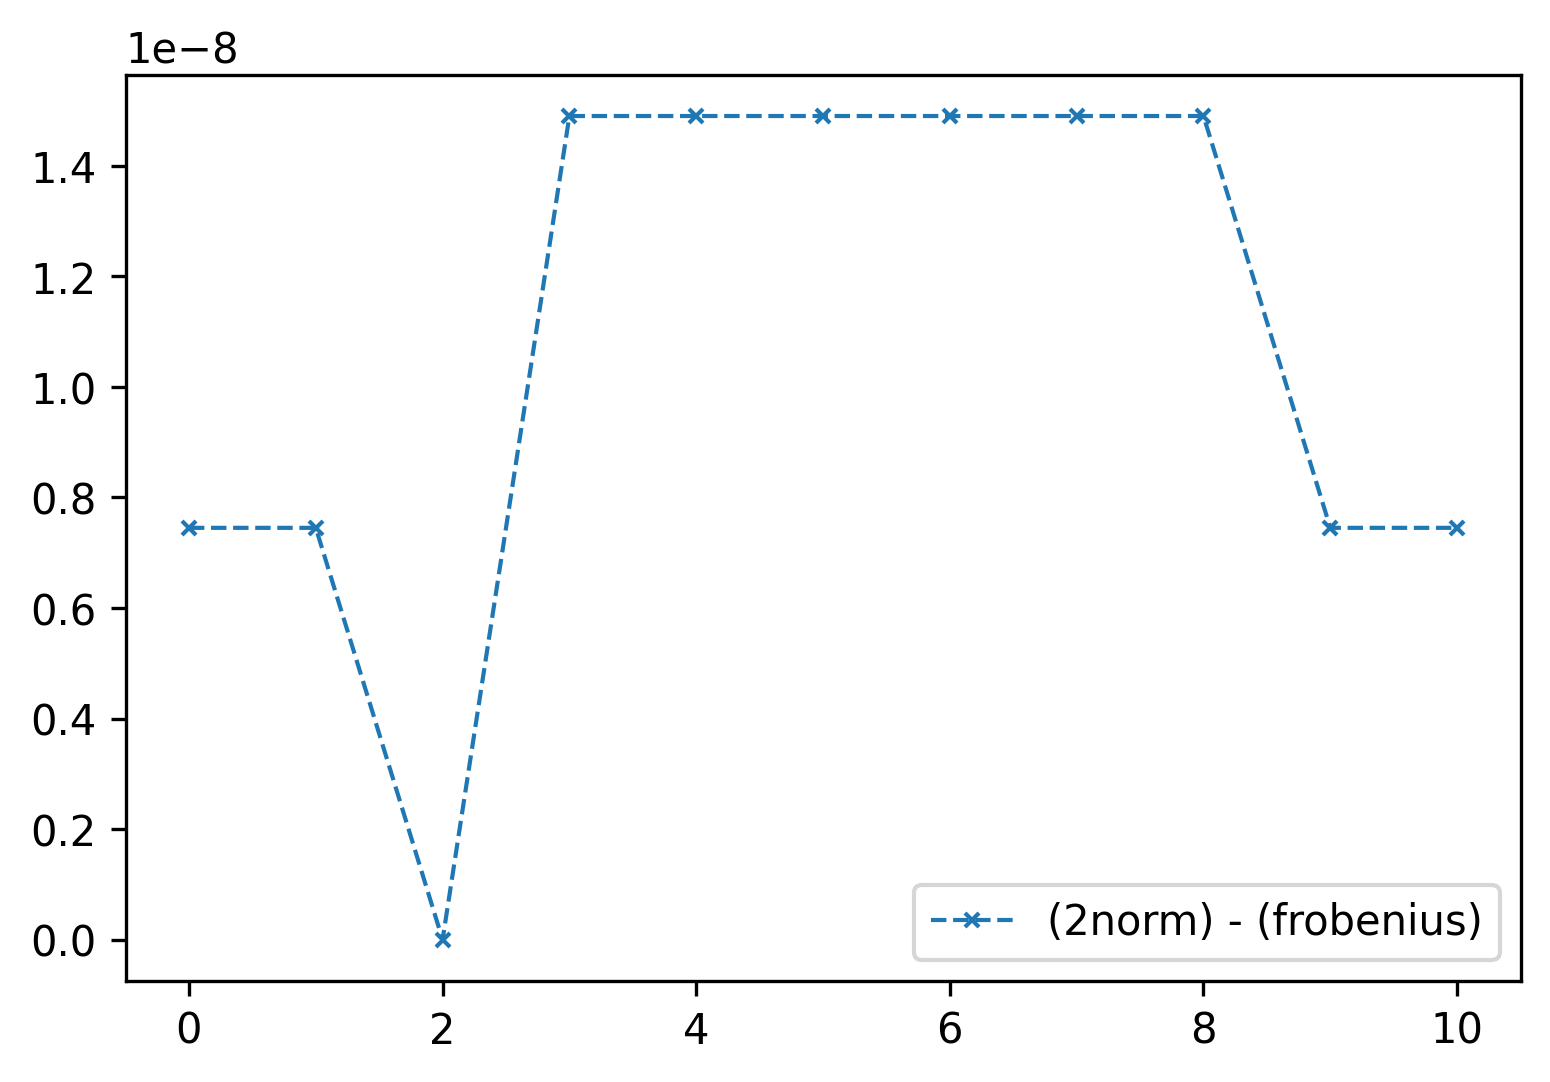

In [272]:
fig = plt.figure(dpi=300)
plt.plot(range(11), [v-f for f,v in zip(cost_list_fro,cost_list_2norm)], '--x', label='(2norm) - (frobenius)', markersize=3.5, linewidth=1.0)
plt.legend()
print(f'difference between functions: {cost_list_2norm[-1] - cost_list_fro[-1]}')

# Thoughts

1. If I want to use the method with kraus operators, I have to be careful. Becuase it still possible to generate the kraus operators for these systems of $N=6$ but they would be big and acting on many bond dimensions at at time. Besides, I would have to decide how to distribute the kraus dimension among the different sites.

2. To achieve this, I can perform a second optimization of each layer s.t: 
$$Y_i = \bigotimes_n Z^{[n,n+1]}$$
With Z, some operators acting only on neighbouring sites.

3. The code is a bit messy, I think I should separate the contraction with the actual cost function that I am using. Maybe just changing the naming of the functions?

4. **NOTE**: no boundary conditions are being implemented now

5. I am waiting the results to see if changing the cost function changes anything: it barely changes something to be honest. UPDATE: the optimization does help, but as we can see, the cost (norm difference) is already quite low so the change is also not so significant.

6. Read more on the error mitigation paper and see if I can get any useful input from it. 
    > Ideas: 
    > - they transform the problem to a "linear problem"
    > - where do they use the rayleigh quotient?
    > - what optimization method do they use? GDS also?
7. **NOTE**: don't forget what Ayse did. I have learned a bit about matrix manifolds, should look into that direction as well.

# TODO:
1. <s>Improve naming convention for `cost_fn` and `loss_fn`  </s>.
2. <s>Have a code implementation where I can use JIT even when passing a parameter like `loss_fn`. Maybe solved by (1)? </s>
3. Implement another optimization step to distribute $Y_i$ onto terms I can exress as kraus operators on NN.
4. Test if they make a difference in the accuracy of the time evolution
5. Implement boundary conditions. How?

# Optimizing to get NN terms:

In [310]:

def cost_xi(Z1,Z2,Z3, *, Xi, loss_fn):
    """
    cost function for a split of a layer Y_i (X_i) onto 3 blocks tensored
    
    Here we are using only half of the layer: X_i such that Y_i = X_i @ X_i.adj().T
    and we want to get Z1, Z2, Z3 such that: X_i = Z1 (x) Z2 (x) Z3
    and then: Y_i = Z1 @ Z_i.adj().T  (x) Z2 @ Z_i.adj().T (x) Z3 @ Z_i.adj().T
    """
    Z_total = jnp.kron(Z1, jnp.kron(Z2, Z3))
    return loss_fn(Z_total, Xi)

In [315]:
X1.shape
test = jnp.ones((2**4,2**4))
cost_xi(*[test]*3, Xi=X1, loss_fn=frobenius_norm)

DeviceArray(4095.5, dtype=float32)

In [ ]:
# if the legs are actually grouped by site (4 legs per site), then I would have to reorder the exp legs
# but it seems weird if that is the case when using vectorize.
# i think i can check if its correct from how i vectorize the lindbladian that gives rise to the exponential?

# <center> After 06.06 Meeting

# Testing the superoperator <-> choi conversion

In [11]:
# lets use the e^odd to check this
from opentn.transformations import super2choi, choi2super
choi = super2choi(exp_Lvec_odd, dim=2**N)

np.allclose(choi2super(choi, dim=2**N), exp_Lvec_odd)

True

# Need to check if the $e^{\mathcal{L}_o}$ is correctly produced

In [56]:
# This is how it is produced above
# exp_Lvec_odd =jscipy.linalg.expm(Lvec_odd*t/2) 
# exp_Lvec_even = jscipy.linalg.expm(Lvec_even*t) 
# These act on [0,1] [2,3] [4,5]
# NOW, compare when tensor product the individual 2 site terms
super = lindbladian2super(Li=[Lnn], dim=Lnn.shape[0])
super_exp = scipy.linalg.expm(super*t/2)
print(super_exp.shape)
super_exp_full = jnp.kron(super_exp, jnp.kron(super_exp, super_exp))
print(super_exp_full.shape)
# now that we the full thing, check if they are the same
print(jnp.allclose(super_exp_full, exp_Lvec_odd))
# We see its false, as expected. So we have to rearange the legs!
# first reshape it to have 12 legs on each side with local dimension 2 each. We use 4 because we have both sides of the matrix
super_exp_full = jnp.reshape(super_exp_full, newshape=[2]*4*N)
# now reshuffel the legs.
# NOTE: METHOD 1
new_order = [0,1,4,5,8,9,2,3,6,7,10,11]
super_exp_full = jnp.transpose(super_exp_full, axes=new_order + list(jnp.array(new_order) + 2*N))
# NOTE: METHOD 2
# source_idx = [2,3,6,7]
# destination_idx = [6,7,8,9]
# super_exp_full = jnp.moveaxis(super_exp_full, source=source_idx + list(jnp.array(source_idx) + 2*N), destination=destination_idx + list(np.array(destination_idx) + 2*N))
# go back to original shape
super_exp_full = jnp.reshape(super_exp_full, newshape=exp_Lvec_odd.shape)
print(jnp.allclose(super_exp_full, exp_Lvec_odd))

(16, 16)
(4096, 4096)
False
True


# Now redoing the cost function

In [12]:
# Now I should re do the simulations!
# redo the cost function. The one that is positive semidefinite is the choi matrix.
# so Y = Choi matrix = X X+
# the one that acts on the vectorization of the density matrix (LPDO) is the superoperator (?)
# or rather: we are splitting: e^L = e^1 e^2 e^3 so these are the ones that should be multiplied at the end in the cost function

def frobenius_norm(A,B):
    return jnp.linalg.norm(A-B, ord='fro')

@jit
def contractions(Xs):
    "Xs are assumed to be the square roots of the PSD matrices (Choi)"
    Ys = []
    for X in Xs:
        # convert each of the X into a matrix
        if X.ndim > 2:
            X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
        Y = jnp.dot(X, X.T.conj())
        Ys.append(Y)
    # convert to superoperators
    Ys_super = [choi2super(choi=Y) for Y in Ys]
    Y_total = Ys_super[0]
    for Y in Ys_super[1:]:
        Y_total = jnp.dot(Y, Y_total)
    return Y_total

def cost_fn(X1, X2, X3, loss_fn):
    "cost function for 'troterization' of exponential. The choi matrix is the one that should be PSD"
    # NOTE: we are going to accept the Xi that correspond to the choi matrix
    # --- choi matrices ---
    Xs = [X1,X2,X3]
    # --- superoperators ---
    Y_total = contractions(Xs)
    
    assert exp_Lvec.ndim == Y_total.ndim == 2, 'Y_total should be a matrix'
    return jit(loss_fn)(exp_Lvec, Y_total)

# The problem is now I have to deal with the small eigenvalues of the choi matrix resulting from the exp of superoperator

In [57]:
# just to check something, see what are the eigenvalues of the individual superop for odd sites (NN)
C_NN = super2choi(super_exp)
print(jnp.allclose(C_NN.conj().T ,C_NN)) # HERMITIAN: PASS
eigvals_NN, eigvecs_NN = np.linalg.eigh(C_NN)
# print(eigvals_NN)
for eig in eigvals_NN:
    if abs(eig) > 1e-9:
        print(eig)

True
0.0012492190754190933
3.9987507809245812


In [59]:
C = super2choi(super=exp_Lvec_odd, dim=2**N)
# check if its hermitian
print(jnp.allclose(C.conj().T ,C)) # PASS
# check the eigenvalues
eigvals, eigvecs = np.linalg.eigh(C)
print(eigvals)
# before: -1.4772072e-05 -1.0541916e-05 -8.1017006e-06 ...  1.9974880e-02
# 1.9975079e-02  6.3940044e+01]

True
[-1.82560301e-14 -1.58762532e-14 -1.53603571e-14 ...  1.99750228e-02
  1.99750228e-02  6.39400562e+01]


In [62]:
print(len(eigvals))
print(np.max(eigvals)) # stays the same
print(np.min(eigvals)) #min from before: DeviceArray(-1.4772072e-05, dtype=float32)

4096
63.940056209009995
-1.82560300665938e-14


In [63]:
print(np.max(eigvals)/np.min(eigvals))

-3502407477188160.5


In [74]:
tol = 1e-8
negative = 0
outside_tol = 0
for eig in eigvals:
    if (eig)<0:
        negative += 1
    if abs(eig) < tol:
        outside_tol += 1
    else:
        print('eig: ',eig)
print(negative)
print(outside_tol)

eig:  6.240243726379776e-06
eig:  6.240243726835095e-06
eig:  6.240243727286527e-06
eig:  0.019975022769784245
eig:  0.019975022769785498
eig:  0.019975022769785994
eig:  63.940056209009995
1504
4089


In [123]:
positive_eigvals = jnp.array([eig if abs(eig)>tol else 0 for eig in eigvals])
C_pos = eigvecs@jnp.diag(positive_eigvals)@eigvecs.conj().T

In [124]:
jnp.allclose(C, C_pos)

DeviceArray(True, dtype=bool)

In [129]:
# method 1 for making the new X:
eigvecs_pos = np.empty_like(eigvecs)
for i, eig in enumerate(eigvals):
    if abs(eig) < tol:
        eig = 0
    eigvecs_pos[:,i] = eigvecs[:,i]*jnp.sqrt(eig)

# jnp.allclose(C, eigvecs_pos@eigvecs_pos.conj().T): True

In [130]:
# method 2:
D_sqrt = np.diag([jnp.sqrt(eig) if abs(eig)>=tol else 0 for eig in eigvals])
eigvecs_pos2 = jnp.tensordot(eigvecs, D_sqrt, axes=(-1,0))
# jnp.allclose(C, eigvecs_pos2@eigvecs_pos2.conj().T): True

### DONE! now for $X_2$

In [86]:
negative = 0
outside_tol = 0
for eig in positive_eigvals:
    if (eig)<0:
        negative += 1
    if abs(eig) < tol:
        outside_tol += 1
    else:
        print('eig: ',eig)
print(negative)
print(outside_tol)

eig:  6.2402437e-06
eig:  6.2402437e-06
eig:  6.2402437e-06
eig:  0.019975023
eig:  0.019975023
eig:  0.019975023
eig:  63.940056
0
4089


`LinAlgError: 196-th leading minor of the array is not positive definite`
the error happens even when all eigvals are non negative, because cholesky checks `>` not `>=`. Zeros on diag would also affect, same as small numbers

In [143]:
# scipy.linalg.cholesky(C_pos) # the scipy version and the numpy version give error: not positive semidefinite matrix
# np.array([[1,0],[0,1e-18]])

In [132]:
X1 = eigvecs_pos
C2 = super2choi(super=exp_Lvec_even, dim=2**N)
# check the eigenvalues
eigvals2, eigvecs2 = np.linalg.eigh(C2)
X2 = np.empty_like(eigvecs2)
for i, eig in enumerate(eigvals2):
    if abs(eig) < tol:
        eig = 0
    X2[:,i] = eigvecs2[:,i]*jnp.sqrt(eig)

In [133]:
jnp.allclose(C2, X2@X2.conj().T)

DeviceArray(True, dtype=bool)

In [134]:
negative = 0
outside_tol = 0
for eig in eigvals2:
    if (eig)<0:
        negative += 1
    if abs(eig) < tol:
        outside_tol += 1
    else:
        print('eig: ',eig)
print(negative)
print(outside_tol)

eig:  2.4937591048133798e-05
eig:  0.03992510404958848
eig:  0.0399251040495899
eig:  63.92012485430975
1248
4092


In [13]:
# doing the multiplication 'manually' to see wtf is wrong
exp_approx = exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd
# evaluating the frobenius norm cost function
print(frobenius_norm(exp_Lvec, exp_approx)) #even doing jit(frobenius_norm) gives the same

2.9053286e-08


In [158]:
# the only thing left is doing the contraction manually:
def contractions_test(Xs):
    "Xs are assumed to be the square roots of the PSD matrices (Choi)"
    Ys = []
    for X in Xs:
        # convert each of the X into a matrix
        if X.ndim > 2:
            X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
        Y = X@X.T.conj()
        Ys.append(Y)
    # convert to superoperators
    Ys_super = [choi2super(choi=Y) for Y in Ys]
    Y_total = Ys_super[0]
    for Y in Ys_super[1:]:
        Y_total = Y@Y_total
    return Y_total
exp_approx_from_fn_test = contractions_test([X1,X2,X1])

In [430]:
frobenius_norm(exp_Lvec,exp_approx_from_fn_test) # NOTE: the result does change when we change dot for @, but it actually becomes higher, and slower.

DeviceArray(1.1478624e-05, dtype=float32)

In [147]:
# now lets to every step 'manually' to see if sth changes
exp_approx_from_fn = contractions([X1, X2, X1])
jnp.allclose(exp_approx_from_fn, exp_approx)

DeviceArray(True, dtype=bool)

In [431]:
# since they are the same, then what is different? is it when jitting the function?
frobenius_norm(exp_Lvec,exp_approx_from_fn)

DeviceArray(8.787664e-06, dtype=float32)

In [148]:
cost_fn(X1, X2, X1, frobenius_norm)

DeviceArray(1.4258275e-05, dtype=float32)

> In any case: the results vary a bit if we do it directly from exp() or through `contraction` fn. But this is likely to the approximations done when finding the Xs from exp(Li).  Now lets do a manual step of GDS and see what is going on

In [261]:
cost_eval_test, grad_x_test = jax.value_and_grad(cost_fn, (0,1,2))(X1, X2, X1, loss_fn=frobenius_norm)
# cost_eval_test: 1.4258275e-05

In [262]:
for grad in grad_x_test:
    print(jnp.linalg.norm(grad))

14.552494
14.557098
14.552491


In [190]:
Xo = [X1, X2, X1]
Xi = []
rate = 1e-7
for i in range(len(grad_x_test)):
    Xi.append(Xo[i] - rate*grad_x_test[i])
cost_eval_test_i, grad_x_test_i = jax.value_and_grad(cost_fn, (0,1,2))(*Xi, loss_fn=frobenius_norm)
print(cost_eval_test_i)

5.7061345e-05


| rate | cost          |
|------|---------------|
| 1e-2 | 7.193493      |
| 1e-3 | 0.6897543     |
| 1e-4 | 0.068676315   |
| 1e-5 | 0.006851822   |
| 1-6  | 0.00067363406 |
| 1e-7 | 5.7061345e-05 |


In [182]:
cost_list_fro, xi_fro = gds(fn=cost_fn, x0=[X1, X2, X1], iter=3, loss_fn=frobenius_norm, rate=1e-7)

Starting iteration: 0
Starting iteration: 1
Starting iteration: 2


In [183]:
cost_list_fro

[DeviceArray(1.4258275e-05, dtype=float32),
 DeviceArray(5.7061345e-05, dtype=float32),
 DeviceArray(2.1285707e-05, dtype=float32),
 DeviceArray(5.2286192e-05, dtype=float32)]

In [186]:
cost_list_fro2, xi_fro2 = gds(fn=cost_fn, x0=xi_fro, iter=5, loss_fn=frobenius_norm, rate=1e-7)

Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4


In [189]:
cost_list_fro3, xi_fro3 = gds(fn=cost_fn, x0=xi_fro2, iter=7, loss_fn=frobenius_norm, rate=1e-8)

Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4
Starting iteration: 5
Starting iteration: 6


In [201]:
cost_list_fro4, xi_fro4 = gds(fn=cost_fn, x0=xi_fro2, iter=7, loss_fn=frobenius_norm, rate=1e-7)

Starting iteration: 0
* Cost function: 5.3281918e-05
Starting iteration: 1
* Cost function: 2.2838882e-05
Starting iteration: 2
* Cost function: 5.2060317e-05
Starting iteration: 3
* Cost function: 2.439097e-05
Starting iteration: 4
* Cost function: 5.3162134e-05
Starting iteration: 5
* Cost function: 2.3597042e-05
Starting iteration: 6
* Cost function: 5.239029e-05


In [203]:
cost_list_fro5, xi_fro5 = gds(fn=cost_fn, x0=xi_fro4, iter=2, loss_fn=frobenius_norm, rate=5e-7)

Starting iteration: 0
* Cost function: 2.4401754e-05
Starting iteration: 1
* Cost function: 0.00034608907


> NOTE: I should return also the gradient? (thinking more about it maybe not)  

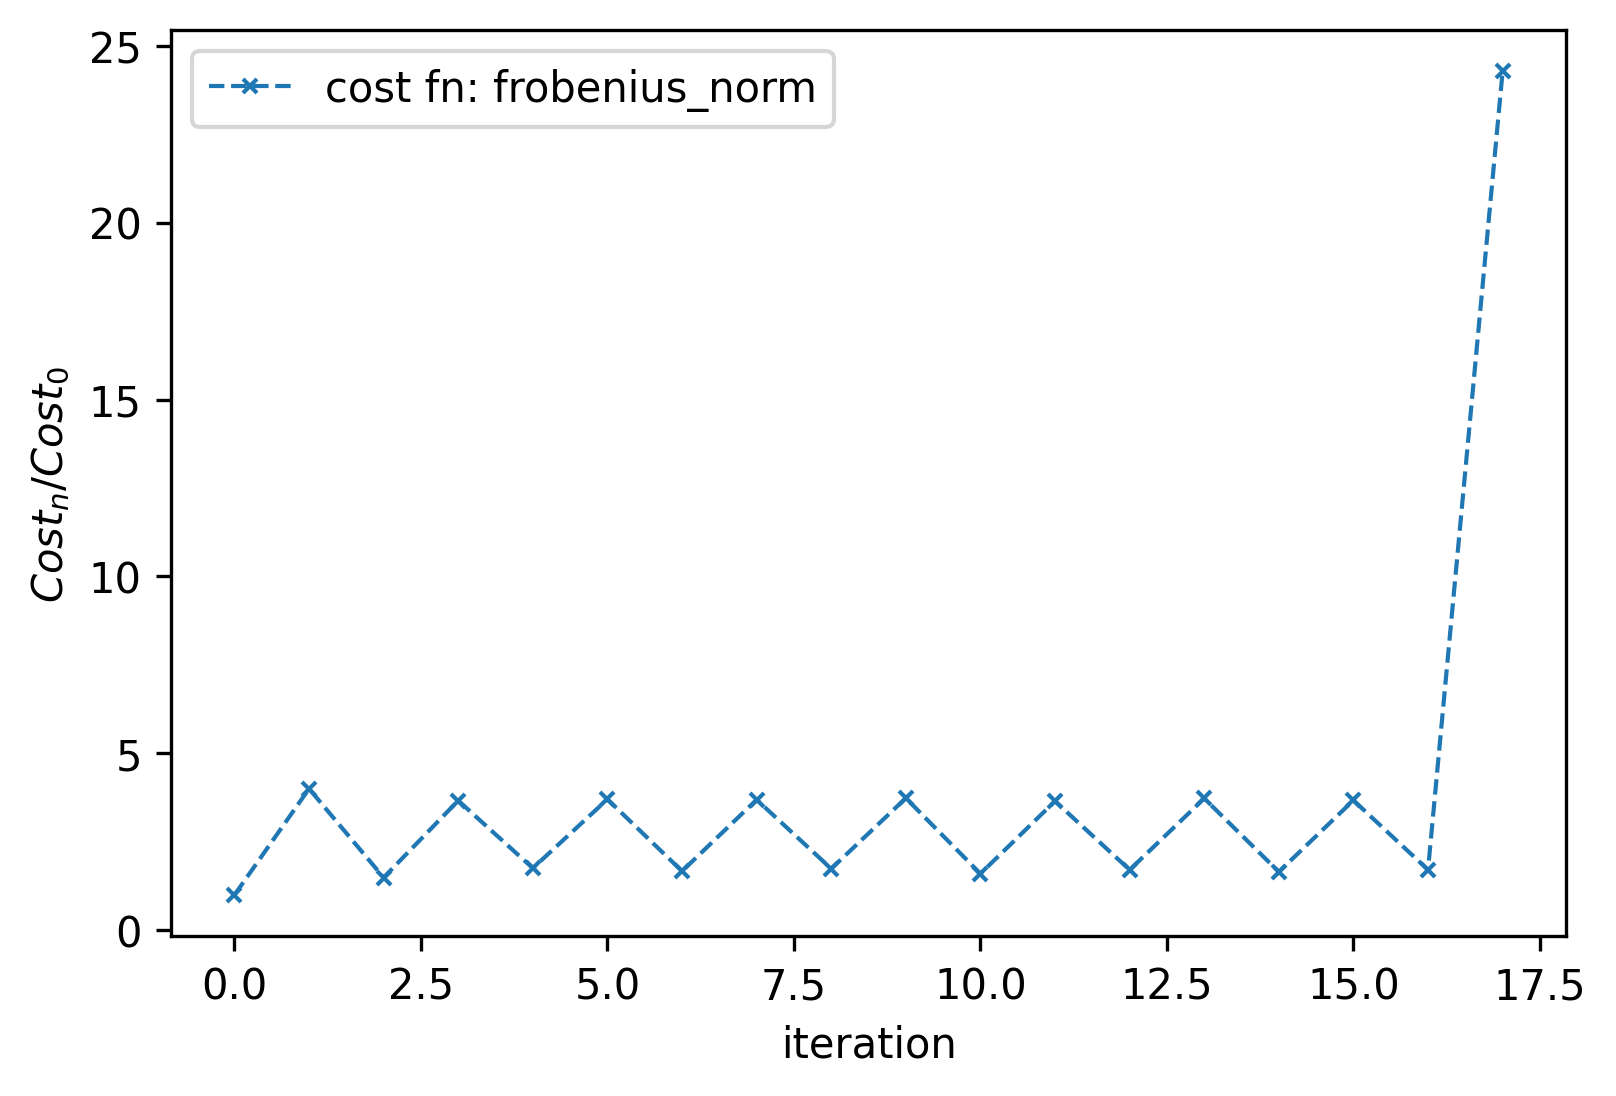

In [204]:
fig = plt.figure(dpi=300)
plt.plot(range(18), [c/cost_list_fro[0] for c in cost_list_fro + cost_list_fro2[1:] + cost_list_fro4 + cost_list_fro5], '--x', label='cost fn: frobenius_norm', markersize=3.5, linewidth=1.0)
plt.ylabel(r'$Cost_n/Cost_0$')
plt.xlabel('iteration')
plt.legend()

# Ideas what to change:
- loss fn: cosine similarity
- change to other optimizer: momentum GDS, SGDS, other? (adam, etc.)
- ask for help :(

In [281]:
from opentn.optimization import calculate_norms, update

In [418]:
def cosine_similarity(A:np.ndarray,B:np.ndarray):
    # flatten them as this is defined for vectors.
    a = vectorize(A)
    b = vectorize(B)
    # taking the real part as otherwise the grad calculation should guarantee cost_fn to be holomorphic
    return -(a@b.T.conj() / (jnp.linalg.norm(a)*jnp.linalg.norm(b))).real
    # NOTE: changed the function to have the most negative when A = B

In [419]:
cosine_similarity(exp_Lvec, exp_Lvec) # all with jnp

DeviceArray(-0.99999994, dtype=float32)

In [357]:
cosine_similarity(exp_Lvec, exp_Lvec) # all with jnp:-0.99999315

DeviceArray(-0.99999315, dtype=float32)

In [382]:
frobenius_norm(exp_Lvec, exp_Lvec)

DeviceArray(0., dtype=float32)

In [406]:
test_matrices = [exp_approx, exp_approx_from_fn_test, exp_approx_from_fn, exp_Lvec]
for test in test_matrices:
    print(cosine_similarity(exp_Lvec, test)) 
# WHAT IS GOING ON HERE? now the values are higher than one? how can you even distinguish from numerical noise

-1.000000000000195
-1.0000000000001705
-0.9999925
-1.0000000000002003


without jax on process and without jax on cost function:
-1.000000000000195
-1.0000000000001705
-0.9999925
-1.0000000000002003

without jax on process but still jax in cost function:
-0.99999994
-0.9999999
-0.9999924
-0.99999994

with jax scipy and numpy in process and cost function:
-0.99999326
-0.9999925
-0.99999255
-0.99999315

process == how we calculate the superoperator exponential

> NOTE: having np.linalg.norm instead of jnp version in the cost function makes an error happen

In [424]:
cost_list_cos_np, grads_list_cos_np, params_list_cos_np = gds(fn=cost_fn, x0=[X1, X2, X1], iter=5, loss_fn=cosine_similarity, rate=1e2)

Starting iteration: 0
* Cost function: -0.9999924
Starting iteration: 1
* Cost function: -0.9999874
Starting iteration: 2
* Cost function: -0.9999894
Starting iteration: 3
* Cost function: -0.9999993
Starting iteration: 4
* Cost function: -0.999989


In [426]:
len(params_list_cos_np)

6

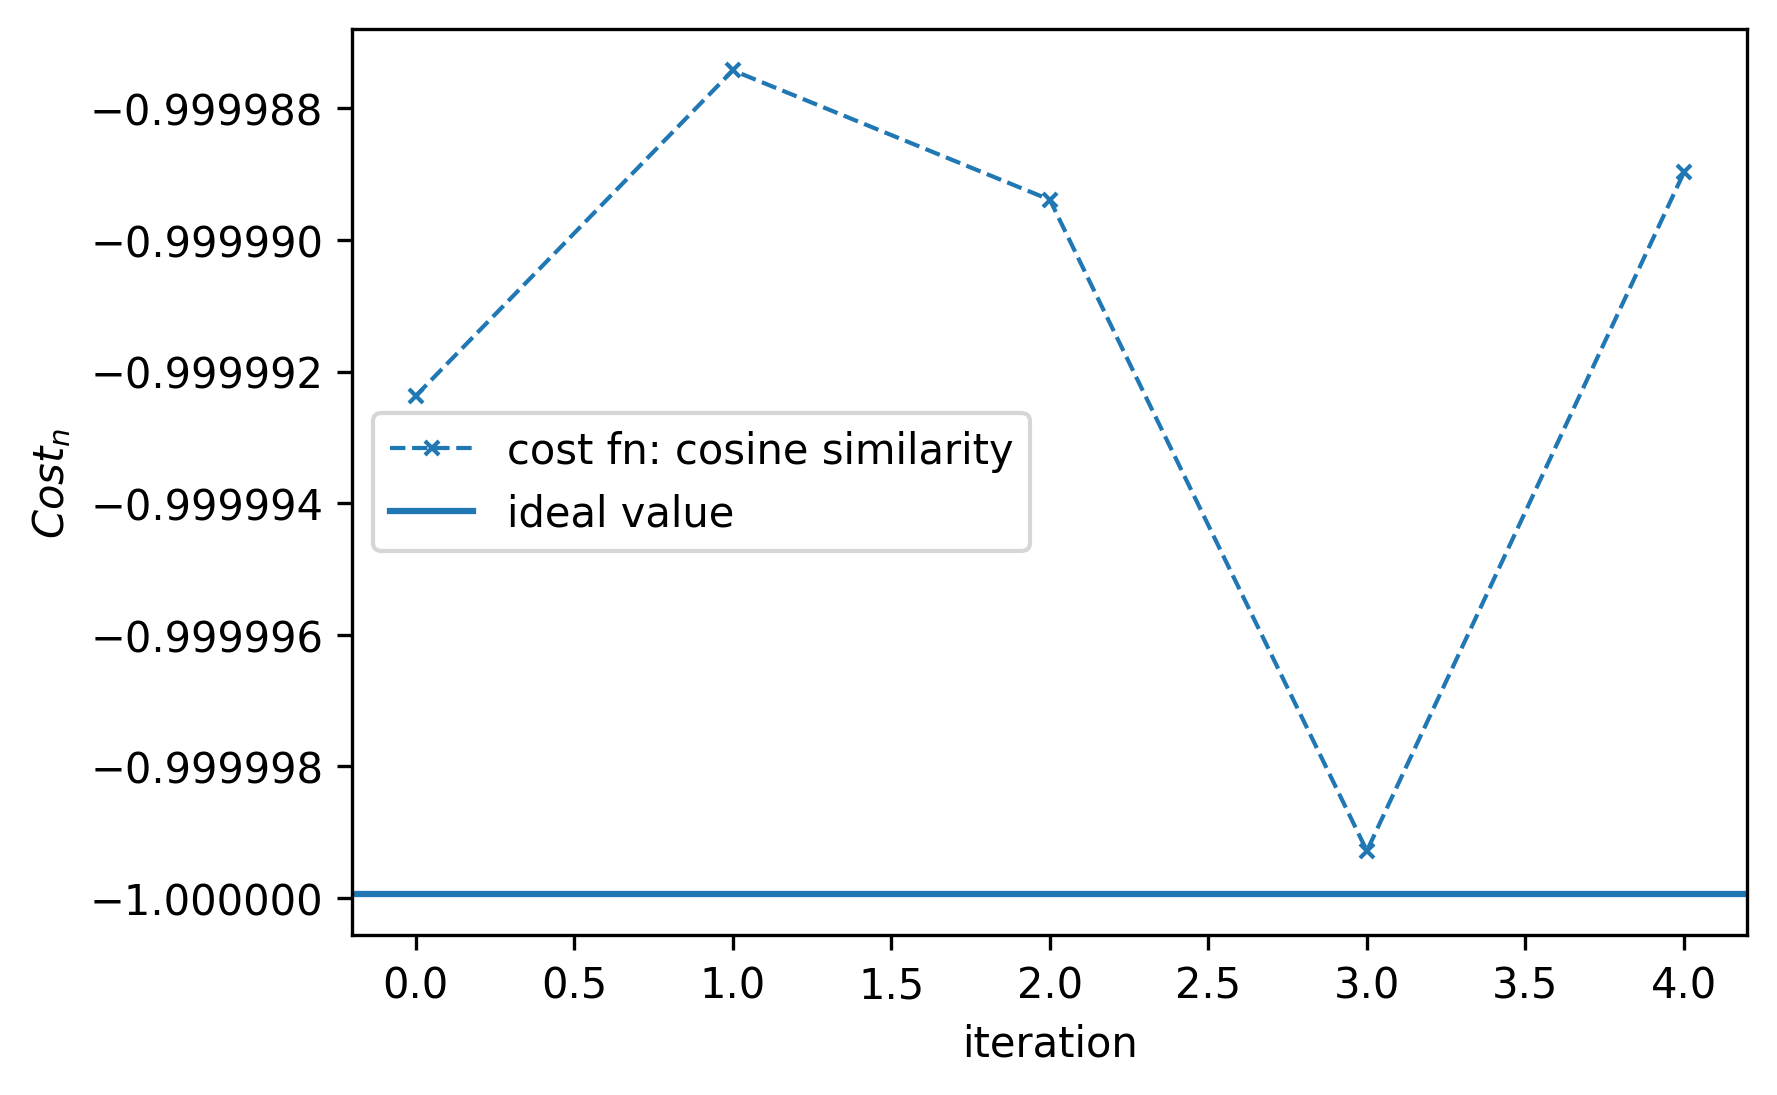

In [425]:
data = cost_list_cos_np
l = len(data)
fig = plt.figure(dpi=300)
plt.plot(range(l), [(d) for d in data], '--x', label='cost fn: cosine similarity', markersize=3.5, linewidth=1.0)
plt.axhline(y=-0.99999994, label='ideal value')
plt.ylabel(r'$Cost_n$')#/Cost_0$')
plt.xlabel('iteration')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

In [348]:
# based on the values we see these are the simulations when jax was used for process and cost fn
cost_list_cos, xi_cos, grads_list_cos = gds(fn=cost_fn, x0=[X1, X2, X1], iter=2, loss_fn=cosine_similarity, rate=1e2)

Starting iteration: 0
* Cost function: -0.99999255
Starting iteration: 1
* Cost function: -0.99998635


In [352]:
cost_list_cos2, xi_cos2, grads_list_cos2 = gds(fn=cost_fn, x0=xi_cos, iter=5, loss_fn=cosine_similarity, rate=1e2)

Starting iteration: 0
* Cost function: -0.9999823
Starting iteration: 1
* Cost function: -0.99999696
Starting iteration: 2
* Cost function: -0.99999624
Starting iteration: 3
* Cost function: -0.9999919
Starting iteration: 4
* Cost function: -0.9996546


In [374]:
for i, grads in enumerate(grads_list_cos2):
    print('iteration:', i)
    calculate_norms(grads)
    print()

iteration: 0
4.5176907e-06
4.518905e-06
4.5176935e-06

iteration: 1
7.951053e-06
7.950952e-06
7.951026e-06

iteration: 2
6.640059e-05
6.640358e-05
6.640057e-05

iteration: 3
0.0005564675
0.00055648765
0.0005564671

iteration: 4
0.0046689897
0.004669166
0.004668987



In [356]:
data

[DeviceArray(-0.99999255, dtype=float32),
 DeviceArray(-0.99998635, dtype=float32),
 DeviceArray(-0.9999823, dtype=float32),
 DeviceArray(-0.99999696, dtype=float32),
 DeviceArray(-0.99999624, dtype=float32),
 DeviceArray(-0.9999919, dtype=float32),
 DeviceArray(-0.9996546, dtype=float32)]

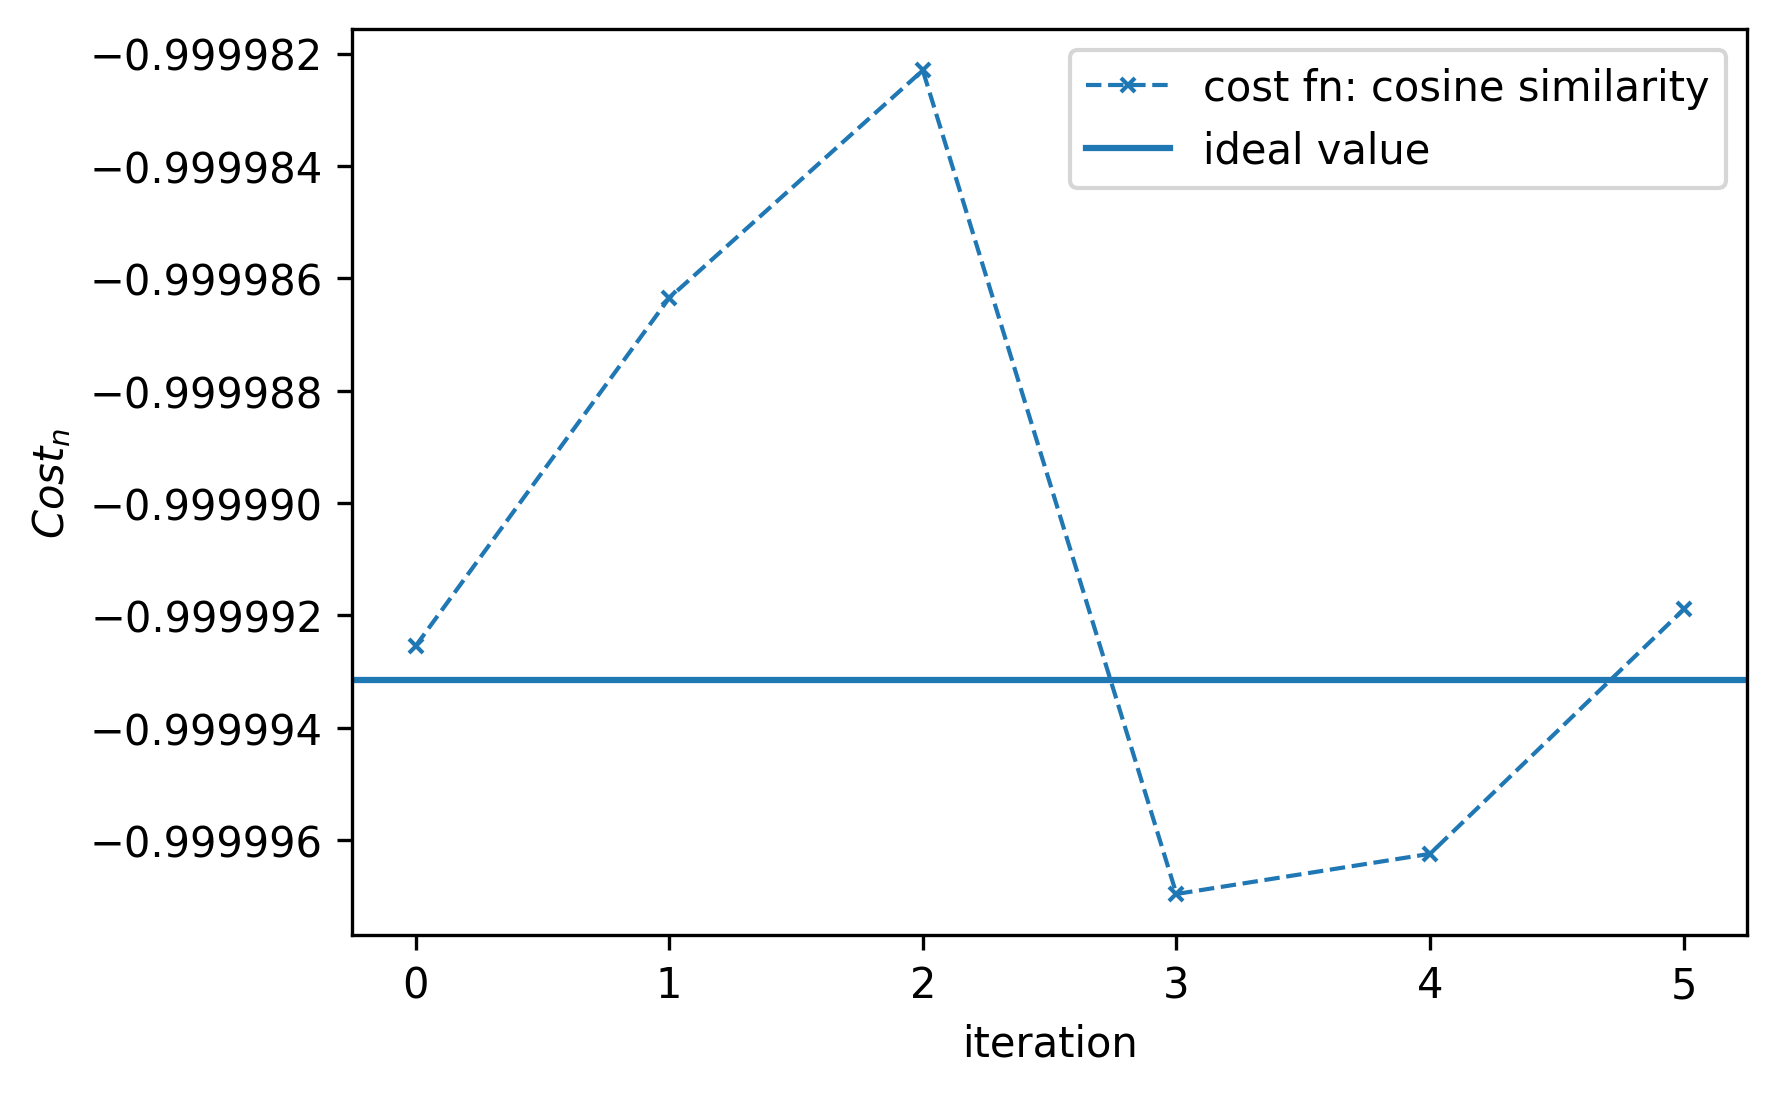

In [377]:
data = cost_list_cos + cost_list_cos2[:-1]
l = len(data)
fig = plt.figure(dpi=300)
plt.plot(range(l), [(d) for d in data], '--x', label='cost fn: cosine similarity', markersize=3.5, linewidth=1.0)
plt.axhline(y=cosine_similarity(exp_Lvec, exp_Lvec), label='ideal value')
plt.ylabel(r'$Cost_n$')#/Cost_0$')
plt.xlabel('iteration')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

In [432]:
# optional cosine cost value
print(cost_list_cos_np[3])
optimal_params = params_list_cos_np[3]

-0.9999993


In [433]:
# lets see what is the cost function with frobenius norm of the optimal parameters obtained in cosine 
# test_matrices = [exp_approx, exp_approx_from_fn_test, exp_approx_from_fn, exp_Lvec]
for test in test_matrices:
    print(frobenius_norm(exp_Lvec, test)) 

# checking what is the cost function of all the params we found with the other method
for params in params_list_cos_np:
    print(cost_fn(*params, loss_fn=frobenius_norm))

2.9053286e-08
1.1478624e-05
8.787664e-06
0.0
8.787664e-06
0.009191272
0.024275228
0.037115347
0.047551747
0.2472178


In [410]:
# now let me try with similar parameters for frobenius again

cost_list_fro_np, xi_fro_np, grads_list_fro_np = gds(fn=cost_fn, x0=[X1, X2, X1], iter=5, loss_fn=frobenius_norm, rate=1e-2)

2.9053286e-08
1.1478624e-05
8.787664e-06
0.0
Starting iteration: 0
* Cost function: 8.787664e-06
Starting iteration: 1
* Cost function: 5.949858
Starting iteration: 2
* Cost function: 2.3600423
Starting iteration: 3
* Cost function: 5.0616364
Starting iteration: 4
* Cost function: 3.1690357


for rate = 1e2 it did not work, changes are way too big!

In [272]:
# old xs
calculate_norms([X1, X2])
calculate_norms(xi_cos)
# are they the same?
jnp.allclose(xi_cos[2], X1) # THEY ARE THE SAME! why did it not change?

8.0
8.0
8.0
8.0
8.0


DeviceArray(True, dtype=bool)

In [ ]:
calculate_norms([exp_Lvec])

63.800568


In [263]:
cost_eval_test, grad_x_test = jax.value_and_grad(cost_fn, (0,1,2))(X1, X2, X1, loss_fn=cosine_similarity)
# cost:0.99999255

In [276]:
calculate_norms(grad_x_test)

1.8529345e-06
1.8532313e-06
1.8529345e-06


In [284]:
# lets see what happens for 3 random matrices
# key = jax.random.PRNGKey(0)
size = X1.shape[0] #4096
Xs_rnd = []
for _ in range(3):
    Xs_rnd.append(np.random.normal(size=(size,size)) / np.sqrt(size*size))
calculate_norms(Xs_rnd)

cost_eval_rnd, grad_x_rnd = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_rnd, loss_fn=cosine_similarity)
cost_eval_rnd

0.9997263
0.9999303
0.9998823


DeviceArray(0.01567012, dtype=float32)

In [285]:
calculate_norms(grad_x_rnd)

0.00083910086
0.0004883077
0.000849503


In [292]:
Xs_rnd_upd = update(Xs_rnd, grad_x_rnd, rate=0.1)
calculate_norms(Xs_rnd_upd)

0.99972624
0.9999303
0.99988234


In [293]:
for i in range(3):
    print(np.allclose(Xs_rnd[i], Xs_rnd_upd[i]))
cost_eval_rnd_upd, grad_x_rnd_upd = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_rnd_updated, loss_fn=cosine_similarity)
cost_eval_rnd_upd

False
False
False


DeviceArray(0.01566995, dtype=float32)

In [295]:
cost_eval_rnd_upd < cost_eval_rnd

DeviceArray(True, dtype=bool)

In [297]:
# try to see what happens with random input for frobenius
cost_eval_fro_rnd, grad_x_fro_rnd = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_rnd, loss_fn=frobenius_norm)
print(cost_eval_fro_rnd)

DeviceArray(63.800568, dtype=float32)

In [303]:
for i in range(3):
    print(jnp.max(grad_x_fro_rnd[i]))

1.6441483e-10
1.5852425e-10
1.5583133e-10


In [322]:
calculate_norms(grad_x_fro_rnd)
Xs_fro_rnd_upd = update(Xs_rnd, grad_x_fro_rnd, rate=1e7)
calculate_norms(Xs_fro_rnd_upd)
cost_eval_fro_rnd2, grad_x_fro_rnd2 = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_fro_rnd_upd, loss_fn=frobenius_norm)
print(cost_eval_fro_rnd2)

1.1954948e-07
1.1952541e-07
1.1953186e-07
2.19502
2.1949813
2.194995
63.80056


In [327]:
for i in range(3):
    print(np.allclose(Xs_rnd[i], Xs_fro_rnd_upd[i]))
for i in range(3):
    print(np.max(Xs_rnd[i]))
    print(np.max(Xs_fro_rnd_upd[i]))

False
False
False
0.0012924935750992306
0.0028501935
0.0013126090138799752
0.0028735925
0.0012934418651066757
0.0028282735


In [328]:
print(cost_eval_fro_rnd2)
print(cost_eval_fro_rnd)
cost_eval_fro_rnd2 == cost_eval_fro_rnd

63.80056
63.800568


DeviceArray(False, dtype=bool)

In [326]:
cost_list_fro_rnd, xi_fro_rnd = gds(fn=cost_fn, x0=update(Xs_fro_rnd_upd, grad_x_fro_rnd2, rate=1e2), iter=2, loss_fn=frobenius_norm, rate=1e7)

Starting iteration: 0
* Cost function: 63.80056
Starting iteration: 1
* Cost function: 250717.44


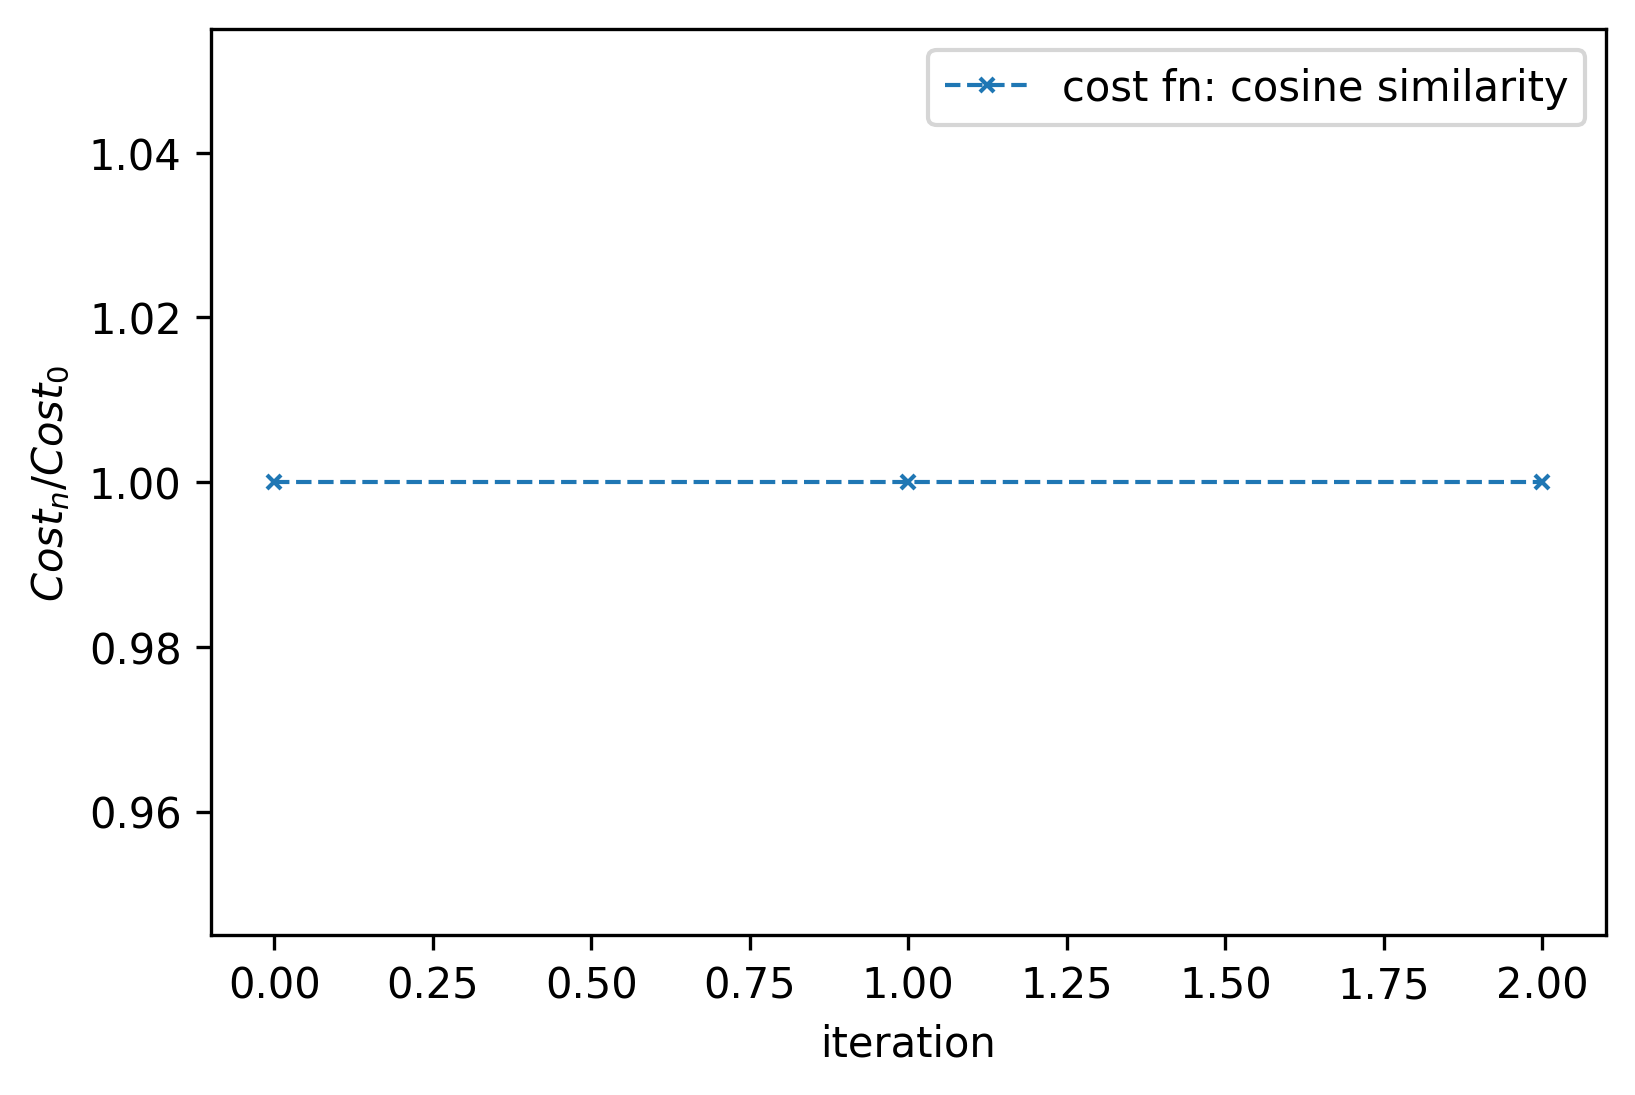

In [216]:
data = cost_list_cos
l = len(data)
fig = plt.figure(dpi=300)
plt.plot(range(l), [d/data[0] for d in data], '--x', label='cost fn: cosine similarity', markersize=3.5, linewidth=1.0)
plt.ylabel(r'$Cost_n/Cost_0$')
plt.xlabel('iteration')
plt.legend()

# UPDATE:
I have tried different cost functions (cosine similarity and frobenius norm). While cosine similarity seems to achieve lower cost function values than the original: -0.9999924 -> -0.9999993. But when using this parameters for the frobenius norm, it does not
achieve a lower value than the original 8.787664e-06.
The values achieved with the params from cosine are: 
* 8.787664e-06.
* 0.009191272
* 0.024275228
* 0.037115347
* 0.047551747
* 0.2472178

Which it is better than the ones achieved with frobenius directly, with rate = 1e-2:
* 8.787664e-06
* 5.949858
* 2.3600423
* 5.0616364
* 3.1690357

While I am out eating lunch I want to try out the scaling of the strang splitting approximation as dt changes. Let's make a function for it.

In [444]:
# we already have Lvec_odd/even, so all I have to do is exponentiate things with different t 
from opentn.transformations import exp_operator_dt

taus = np.logspace(start=2, stop=-7, num=10, base=2)
error = []
approx_tau = []
for tau in taus:
    print(f'tau = {tau}')
    exp_tot = exp_operator_dt(Lvec, tau=tau, library='jax')
    exp_odd = exp_operator_dt(Lvec_odd, tau=tau/2, library='jax')
    exp_even = exp_operator_dt(Lvec_even, tau=tau, library='jax')
    approx = exp_odd@exp_even@exp_odd
    norm_diff = frobenius_norm(exp_tot, approx)
    print('frobenius norm: ', norm_diff)
    approx_tau.append(approx)
    error.append(norm_diff)
   


tau = 4.0
frobenius norm:  9.704956e-06
tau = 2.0
frobenius norm:  1.3742961e-05
tau = 1.0
frobenius norm:  1.2944421e-05
tau = 0.5
frobenius norm:  1.4373253e-05
tau = 0.25
frobenius norm:  1.040848e-05
tau = 0.125
frobenius norm:  6.9836706e-06
tau = 0.0625
frobenius norm:  6.921329e-06
tau = 0.03125
frobenius norm:  7.02425e-06
tau = 0.015625
frobenius norm:  5.139151e-06
tau = 0.0078125
frobenius norm:  6.347265e-06


Text(0.5, 0, 'tau')

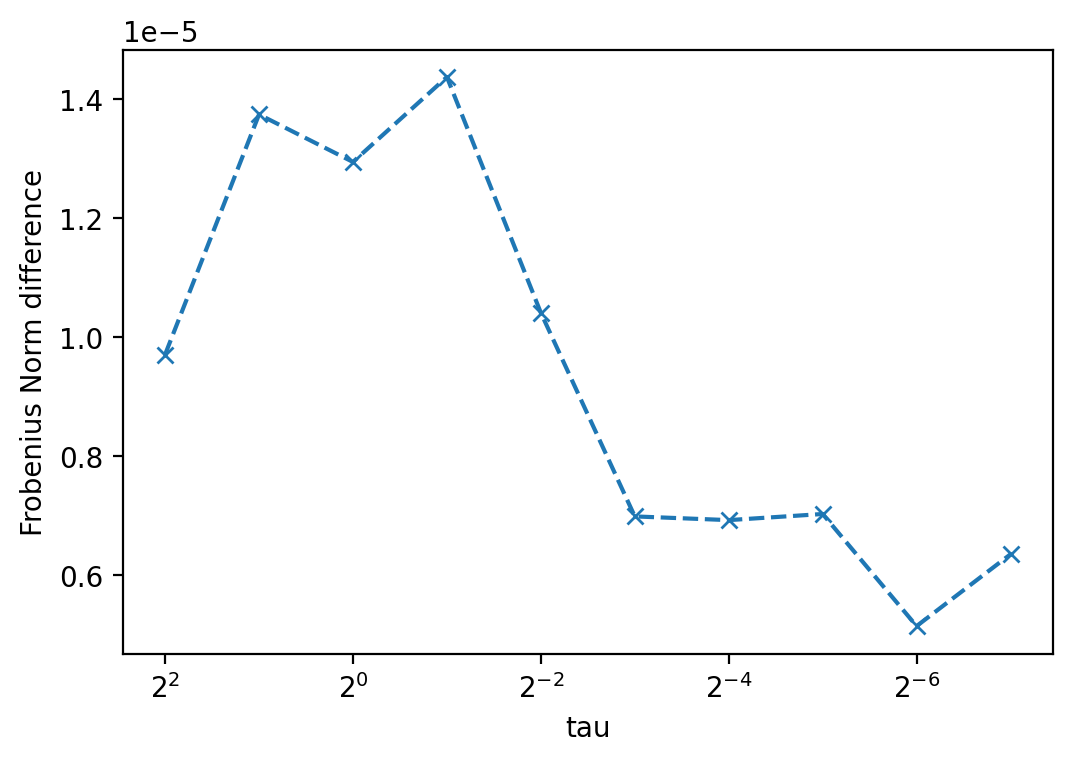

In [457]:
fig = plt.figure(dpi=200)
plt.semilogx(taus, error, '--x',base=2)
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')

In [10]:
# idea: use diamond norm from qutip. Transform matrices onto qutip objects.
# from forestbencharking: https://forest-benchmarking.readthedocs.io/en/latest/examples/distance_measures.html 
# we should be using it for choi matrices
from opentn.optimization import  diamond_norm_distance

# transform superoperators to choi
# choi_approx = super2choi(exp_approx)
# choi_exact = super2choi(exp_Lvec)

# dnorm = diamond_norm_distance(choi_approx, choi_exact)
# dnorm

In [46]:
from opentn.transformations import super2choi, choi2super, kraus2choi, vectorize

Id = np.asarray([[1, 0], [0, 1]])
Xd = np.asarray([[0, 1], [1, 0]])

from scipy.linalg import expm

# Define unitary
theta = 0.4
Ud = expm(-theta*1j*Xd/2)

choi0 = kraus2choi([Id])
choi1 = kraus2choi([Ud])
choi2 = kraus2choi([Xd])

dnorm_test = diamond_norm_distance(choi0, choi1)
dnorm_test

0.3973382099932615

In [45]:
choi1.shape

(4, 4)

In [32]:
vectorize(Id).conj().T @ vectorize(Id).T

2

In [36]:
vectorize(Id).T.shape

(4,)

In [40]:
Id.reshape(-1, 1).shape

(4, 1)